In [2]:
#!pip install pingouin

In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, shapiro, spearmanr, kendalltau
from statsmodels.stats.stattools import jarque_bera 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.compat import lzip

import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

## Reproduction of Determinants of apartment prices in Warsaw by Xinyue Fang

Study made by Xinyue is focused on explaining how different determinants are affecting house price on micro level. Research focuses on factors that influence the price of apartments in Warsaw, following hypothesis are formulated:
1. Influence of apartment type on it's price, it is assumed that tenement apartments should be the cheapest.
2. Non-linear relationship between size and price, it is expected for price to rise rapidly with the increase of flat size.
3. Positive relationship between floor and price - the higher the apartment is situated the higher the price. Lowest floor flats should be the cheapest.
4. Negative relationship between distance from city center and price.
5. Positive relationship between number of ammenities and price.
6. Ownership relationship between type of ownership an price.
7. Positive relationship between existance of elavator and price.
8. Positive rlationship between existance of balcony and price.


## Methods helpful in further steps ##

Method transform_data_from_file() for transforming data to the form used in paper, and aggregate_data() for creating new dataset from additional source files from kaggle.

In [4]:
def transform_data_from_file(file_path: str) -> pd.DataFrame:
    df_transformed = pd.read_csv(file_path)
    df_transformed = df_transformed[(df_transformed['city'] == 'warszawa')]
    df_transformed = df_transformed[
        ['id', 'city', 'type', 'squareMeters', 'floor', 'floorCount', 'centreDistance', 'poiCount', 'ownership',
         'hasBalcony', 'hasElevator', 'price']]
    df_transformed = df_transformed[
        (df_transformed['ownership'] == 'cooperative') | (df_transformed['ownership'] == 'condominium')]
    df_transformed = df_transformed[
        (df_transformed['type'] == 'apartmentBuilding') | (df_transformed['type'] == 'tenement') | (
                df_transformed['type'] == 'blockOfFlats')]
    df_transformed = df_transformed[
        (df_transformed['squareMeters'] > 0) | (df_transformed['floor'] >= 0) | (df_transformed['floorCount'] >= 0) | (
                df_transformed['poiCount'] >= 0) | (df_transformed['centreDistance'] >= 0) | (
                df_transformed['price'] >= 0)]

    df_transformed = df_transformed.dropna()
    df_transformed.drop_duplicates(subset='id', inplace=True)
    df_transformed.drop(axis='columns', labels=['city'], inplace=True)
    return df_transformed


def aggregate_data():
    df_list = []
    for file in os.listdir('data/source'):
        df = transform_data_from_file('data/source/' + file)
        df_list.append(df)
    aggregated_df = pd.concat(df_list, ignore_index=True)
    # Removing same offers across different months
    aggregated_df.drop_duplicates(subset='id', inplace=True)
    aggregated_df.drop(axis='columns', labels=['id'], inplace=True)
    return aggregated_df

Mappings along with methods for creating dummy variables

In [5]:
 mappings = {
        'type': {
            'tenement': 1,
            'blockOfFlats': 2,
            'apartmentBuilding': 3,
        },
        'ownership': {
            'condominium': 1,
            'cooperative': 0,
        },
        'hasBalcony': {
            'yes': 1,
            'no': 0
        },
        'hasElevator': {
            'yes': 1,
            'no': 0
        }
    }
def create_dummy_variables(df: pd.DataFrame) -> pd.DataFrame:
    df['floorType'] = df['floor'] / df['floorCount']

    # Step 2: Create floorTypeDummy using nested conditions
    df['floorType'] = np.where(
        df['floorType'] < 1 / 3, 0,
        np.where(df['floorType'] > 2 / 3, 2, 1)
    )

    df['poiCount'] = np.where(
        df['poiCount'] <= 30, 1, 2
    )

    for key, value in mappings.items():
        df[key] = df[key].map(value)

    df.drop(axis=1, columns=['floor', 'floorCount'], inplace=True)

    return df

Methods for plotting histograms and box plots:

In [6]:
def plot_historgram(df: pd.DataFrame, column: str, xlabel: str, title: str):
    x = df[column].dropna()
    plt.hist(x, bins=20, color='blue', density=True)
    xfit = np.linspace(x.min(), x.max(), 1000)
    yfit = norm.pdf(xfit, loc=x.mean(), scale=x.std())
    plt.plot(xfit, yfit, 'r', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

In [7]:
def plot_boxplot(df: pd.DataFrame, column: str):
    y = df[column].dropna()
    sns.boxplot(y)
    plt.title("Boxplot")
    plt.ylabel(column)
    plt.show()

## Handling Data ##

Original dataset was taken from https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland . Originally research was done based on data from November 2023. Given the abilities of python which we are going to use, we decided to create two separate datasets - one just to reproduce the research and extend one with data since November 2023 up until June 2024. Source dataset from kaggle includes more variables than is required for research and rows for cities which are als not included, so we will need to do some adjusting of datasets.
Way to proceed:
1. Download data from aforementioned source and add csv files into source into data/source directory.
2. Recreate original dataset for November 2023 using transform_data_from_file() and create_dummy_variables() methods and drop id column.
3. Use methods aggregate aggregate_data() and create_dummy_variables() to generate extended dataset.

In [8]:
Apartments_extended = create_dummy_variables(aggregate_data())

In [9]:
Apartments_extended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15805 entries, 0 to 27641
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            15805 non-null  int64  
 1   squareMeters    15805 non-null  float64
 2   centreDistance  15805 non-null  float64
 3   poiCount        15805 non-null  int32  
 4   ownership       15805 non-null  int64  
 5   hasBalcony      15805 non-null  int64  
 6   hasElevator     15805 non-null  int64  
 7   price           15805 non-null  int64  
 8   floorType       15805 non-null  int32  
dtypes: float64(2), int32(2), int64(5)
memory usage: 1.1 MB


In [10]:
Apartments_extended['type'] = pd.Categorical(Apartments_extended['type'],
                                             categories=[1, 2, 3],
                                             ordered=True)
Apartments_extended['type'] = Apartments_extended['type'].cat.rename_categories(['tenement', 'blockOfFlats', 'apartmentBuilding'])

Apartments_extended['floorType'] = pd.Categorical(Apartments_extended['floorType'],
                                                  categories=[0, 1, 2],
                                                  ordered=True)
Apartments_extended['floorType'] = Apartments_extended['floorType'].cat.rename_categories(['low', 'middle', 'high'])

Apartments_extended['ownership'] = pd.Categorical(Apartments_extended['ownership'],
                                                  categories=[0, 1],
                                                  ordered=False)
Apartments_extended['ownership'] = Apartments_extended['ownership'].cat.rename_categories(['cooperative', 'condominium'])

Apartments_extended['hasBalcony'] = pd.Categorical(Apartments_extended['hasBalcony'],
                                                   categories=[0, 1],
                                                   ordered=False)
Apartments_extended['hasBalcony'] = Apartments_extended['hasBalcony'].cat.rename_categories(['no', 'yes'])

Apartments_extended['hasElevator'] = pd.Categorical(Apartments_extended['hasElevator'],
                                                    categories=[0, 1],
                                                    ordered=False)
Apartments_extended['hasElevator'] = Apartments_extended['hasElevator'].cat.rename_categories(['no', 'yes'])

Apartments_extended['poiCount'] = pd.Categorical(Apartments_extended['poiCount'],
                                                 categories=[1, 2, 3],
                                                 ordered=True)
Apartments_extended['poiCount'] = Apartments_extended['poiCount'].cat.rename_categories(['small', 'medium', 'large'])

In [11]:
Apartments_extended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15805 entries, 0 to 27641
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   type            15805 non-null  category
 1   squareMeters    15805 non-null  float64 
 2   centreDistance  15805 non-null  float64 
 3   poiCount        15805 non-null  category
 4   ownership       15805 non-null  category
 5   hasBalcony      15805 non-null  category
 6   hasElevator     15805 non-null  category
 7   price           15805 non-null  int64   
 8   floorType       15805 non-null  category
dtypes: category(6), float64(2), int64(1)
memory usage: 587.3 KB


## Data description and visualization ##

Here we are focusing on recreating original research - visualizing data and checking if it's similar to what has been discovered previously. Additionally, for each variable we are running tests for extended dataset.

# Price - reproduction

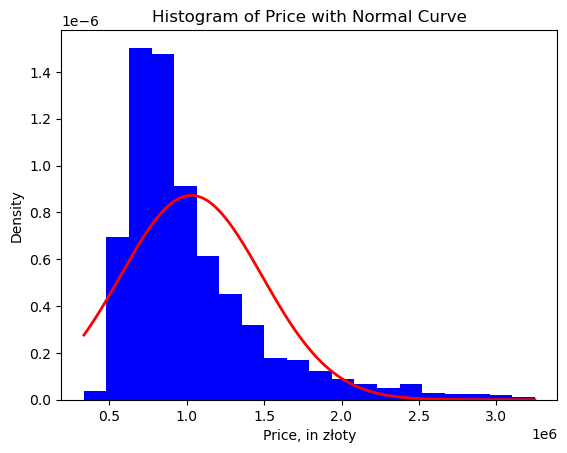

In [12]:
plot_historgram(Apartments_extended, 'price', 'Price, in złoty', 'Histogram of Price with Normal Curve')

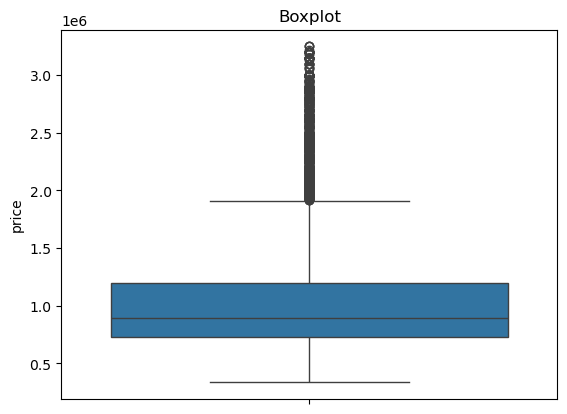

In [13]:
plot_boxplot(Apartments_extended, 'price')

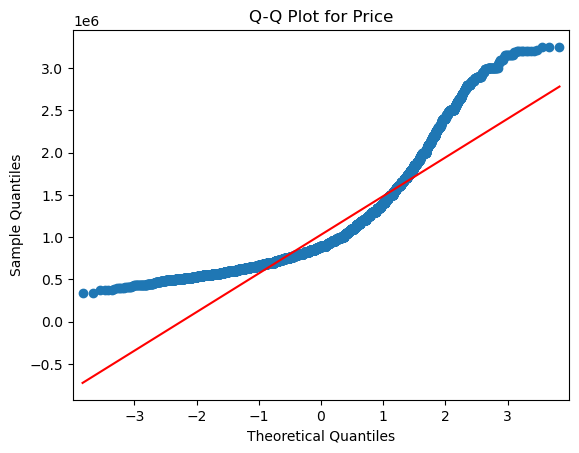

In [14]:
sm.qqplot(Apartments_extended['price'], line='s')
plt.title("Q-Q Plot for Price")
plt.show()

In [15]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartments_extended['price']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartments_extended['price']))

Jarque-Bera Test:
(17626.185129476, 0.0, 1.8010450910829237, 6.7135465966793175)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.8298882087070528, pvalue=1.9971654181950534e-83)


We performed the same tests as for original dataset, and we can reject the null hypothesis that the density distribution is normal as in the original research.

# Square Meters - reproduction

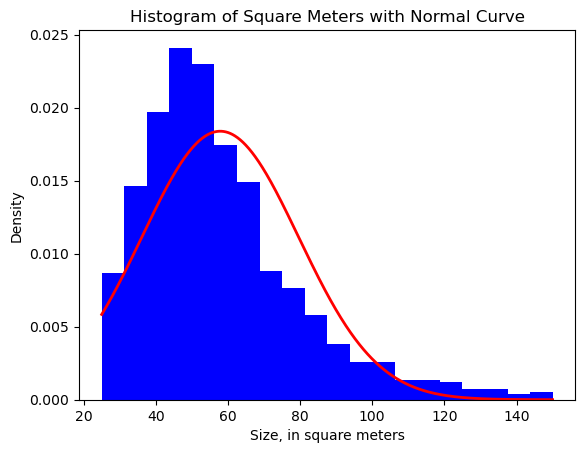

In [16]:
plot_historgram(Apartments_extended, 'squareMeters', 'Size, in square meters', 'Histogram of Square Meters with Normal Curve')

We can see that distribution has similar shape to the original.

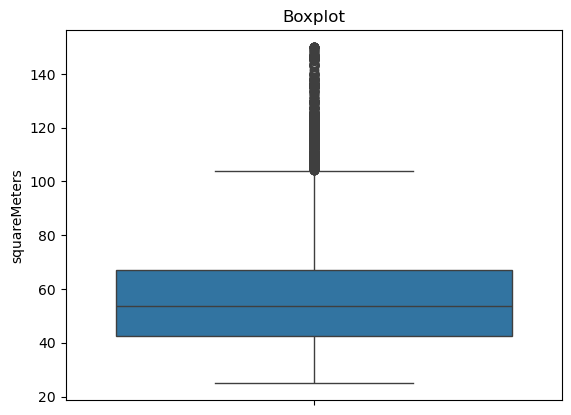

In [17]:
plot_boxplot(Apartments_extended, 'squareMeters')

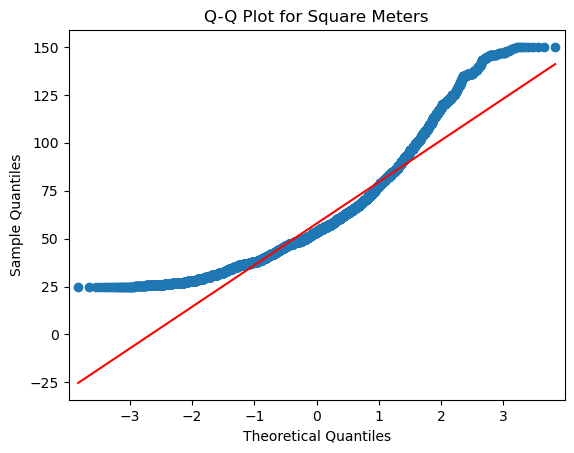

In [18]:
sm.qqplot(Apartments_extended['squareMeters'], line='s')
plt.title("Q-Q Plot for Square Meters")
plt.show()

In [19]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartments_extended['squareMeters']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartments_extended['squareMeters']))

Jarque-Bera Test:
(6895.547279201669, 0.0, 1.2785157129224833, 4.983059689412803)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9109761386417455, pvalue=2.431741203994343e-69)


As in original research we can reject null hypothesis that density distribution is normal.

# Distance from city centre - reproduction

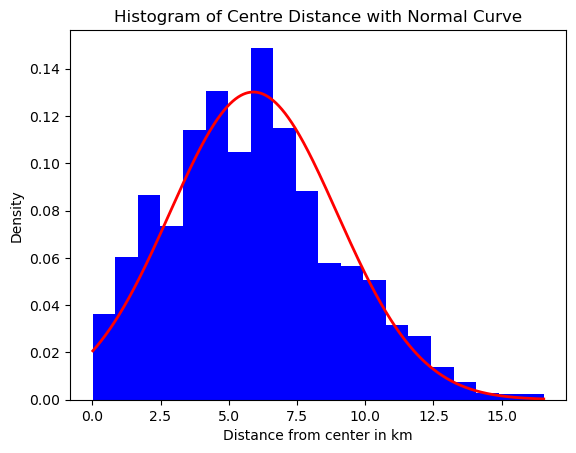

In [20]:
plot_historgram(Apartments_extended, 'centreDistance', 'Distance from center in km',
                'Histogram of Centre Distance with Normal Curve')

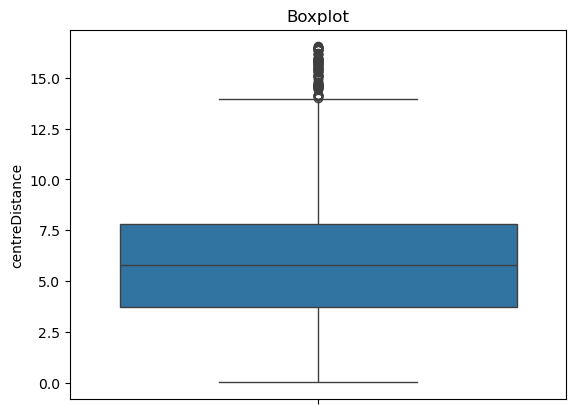

In [21]:
plot_boxplot(Apartments_extended, 'centreDistance')

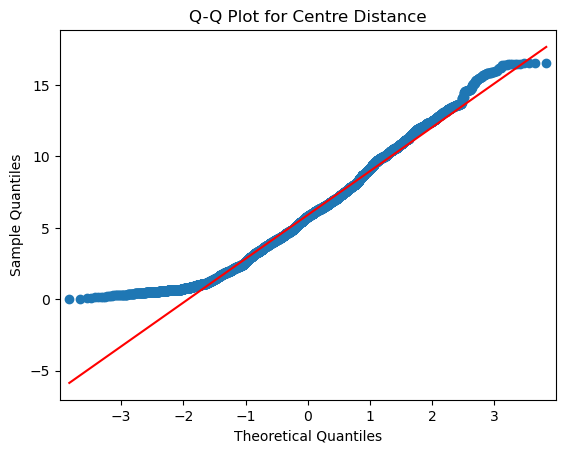

In [22]:
sm.qqplot(Apartments_extended['centreDistance'], line='s')
plt.title("Q-Q Plot for Centre Distance")
plt.show()

In [23]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartments_extended['centreDistance']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartments_extended['centreDistance']))

Jarque-Bera Test:
(474.98701167496415, 7.209097959990678e-104, 0.4130301607567217, 2.8027809513698134)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9821044933533869, pvalue=3.5421787070195214e-40)


Again as in original research we can reject null hypothesis that density distribution is normal. We are not bother with the warning as the p-values are minimal.


# Correlation - Price vs squareMeters

In [24]:
# Spearman correlation: price vs squareMeters
print("Spearman Correlation: Price vs Square Meters")
print(spearmanr(Apartments_extended['price'], Apartments_extended['squareMeters']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartments_extended['price'], Apartments_extended['squareMeters']))

Spearman Correlation: Price vs Square Meters
SignificanceResult(statistic=0.7961536100991684, pvalue=0.0)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=0.6046192589705311, pvalue=0.0)


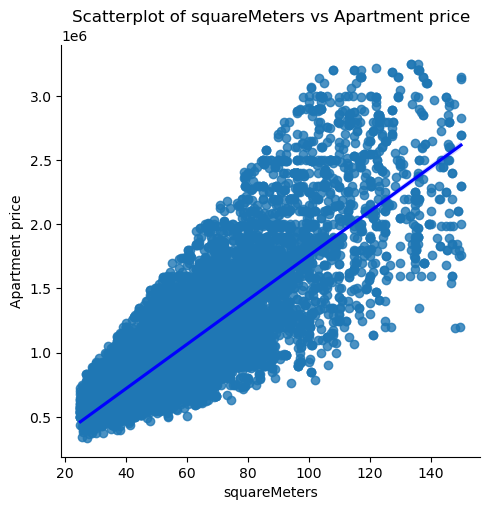

In [25]:
sns.lmplot(x='squareMeters', y='price', data=Apartments_extended, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

# Correlation - price vs distance from city center

In [26]:
# Spearman correlation: price vs centreDistance
print("\nSpearman Correlation: Price vs Centre Distance")
print(spearmanr(Apartments_extended['price'], Apartments_extended['centreDistance']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartments_extended['price'], Apartments_extended['centreDistance']))


Spearman Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.13976548838627084, pvalue=9.091248345398229e-70)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.09289468580136917, pvalue=2.29202397440578e-68)


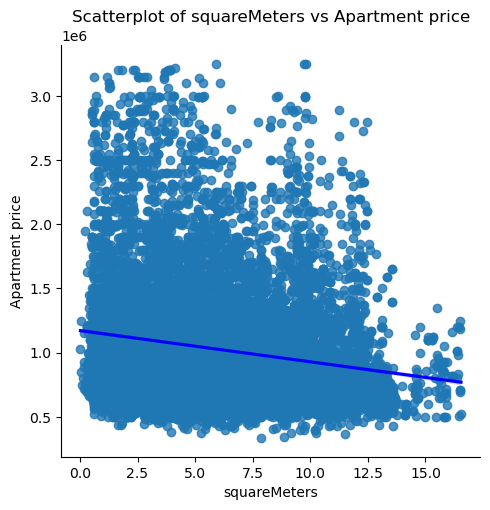

In [27]:
sns.lmplot(x='centreDistance', y='price', data=Apartments_extended, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

# Dummy Variables - reproduction

Price Summary by Type{'tenement': 1, 'blockOfFlats': 2, 'apartmentBuilding': 3}:
                    count          mean            std       min        25%  \
type                                                                          
tenement           1960.0  1.211335e+06  572056.170885  405000.0  798750.00   
blockOfFlats       9559.0  8.900050e+05  324167.795899  335000.0  685000.00   
apartmentBuilding  4286.0  1.253733e+06  527633.210434  340800.0  870348.75   

                         50%        75%        max  
type                                                
tenement            999450.0  1495250.0  3200000.0  
blockOfFlats        800000.0   989000.0  3215000.0  
apartmentBuilding  1140000.0  1499000.0  3250000.0  


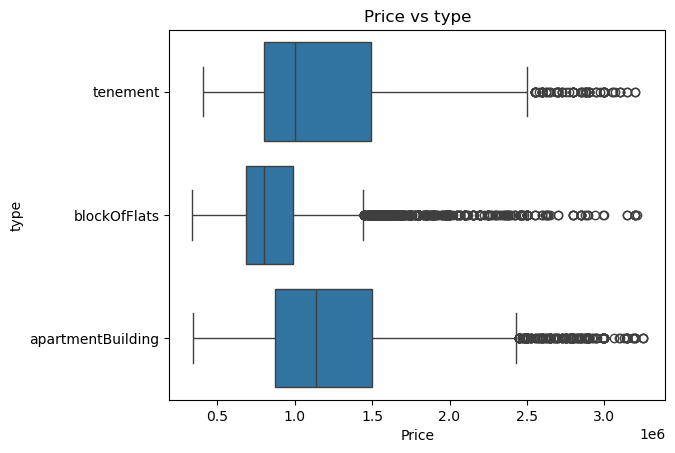

Price Summary by FloortypeNone:
            count          mean            std       min       25%       50%  \
floorType                                                                      
low        3379.0  1.010498e+06  438125.172363  399000.0  715000.0  870000.0   
middle     5956.0  1.033042e+06  456516.888418  340800.0  725000.0  892954.0   
high       6470.0  1.033695e+06  467498.145813  335000.0  729000.0  890000.0   

                 75%        max  
floorType                        
low        1174937.5  3150000.0  
middle     1200000.0  3215000.0  
high       1199000.0  3250000.0  


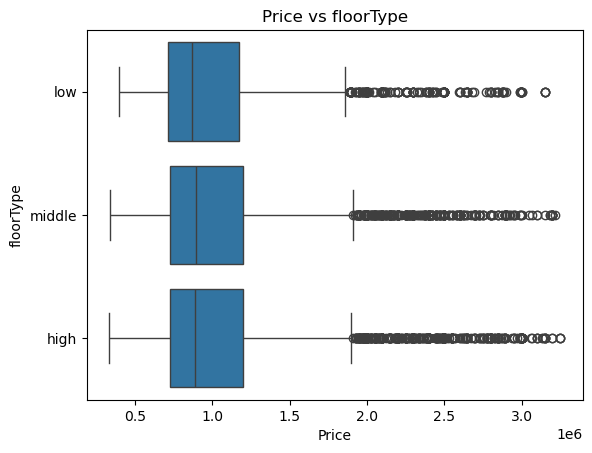

Price Summary by Ownership{'condominium': 1, 'cooperative': 0}:
               count          mean            std       min       25%  \
ownership                                                               
cooperative   2049.0  8.763644e+05  350823.517529  375000.0  679000.0   
condominium  13756.0  1.051149e+06  466871.672611  335000.0  735000.0   

                  50%        75%        max  
ownership                                    
cooperative  795000.0   930000.0  3200000.0  
condominium  899999.5  1227124.5  3250000.0  


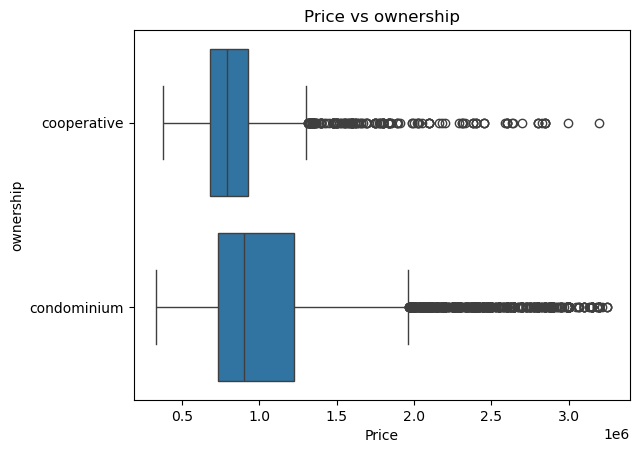

Price Summary by PoicountNone:
            count          mean            std       min       25%       50%  \
poiCount                                                                       
small     12349.0  9.946510e+05  432720.064776  335000.0  711000.0  869000.0   
medium     3456.0  1.149401e+06  518240.782872  375000.0  780000.0  980000.0   
large         0.0           NaN            NaN       NaN       NaN       NaN   

                75%        max  
poiCount                        
small     1150000.0  3250000.0  
medium    1395000.0  3200000.0  
large           NaN        NaN  


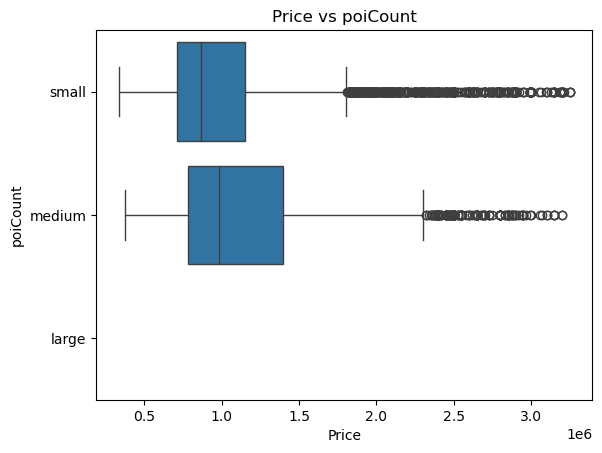

Price Summary by Hasbalcony{'yes': 1, 'no': 0}:
              count          mean            std       min       25%  \
hasBalcony                                                             
no           4951.0  1.007586e+06  467679.777772  335000.0  695000.0   
yes         10854.0  1.038024e+06  452159.151517  340800.0  740000.0   

                 50%        75%        max  
hasBalcony                                  
no          860000.0  1180000.0  3200000.0  
yes         897000.0  1200000.0  3250000.0  


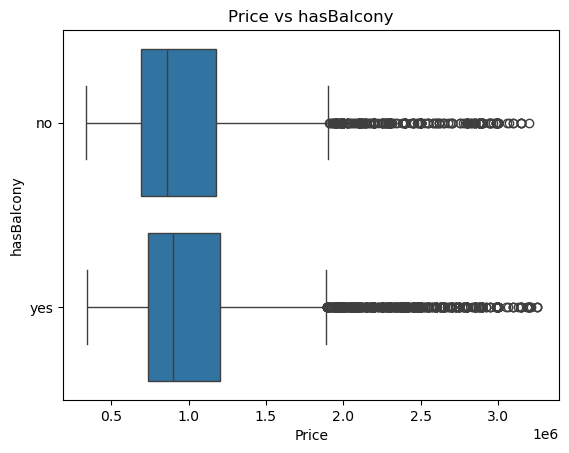

Price Summary by Haselevator{'yes': 1, 'no': 0}:
               count          mean            std       min       25%  \
hasElevator                                                             
no            4449.0  9.672096e+05  412682.774060  335000.0  711000.0   
yes          11356.0  1.052497e+06  471460.314221  340800.0  730000.0   

                  50%         75%        max  
hasElevator                                   
no           840000.0  1083000.00  3215000.0  
yes          900000.0  1230488.75  3250000.0  


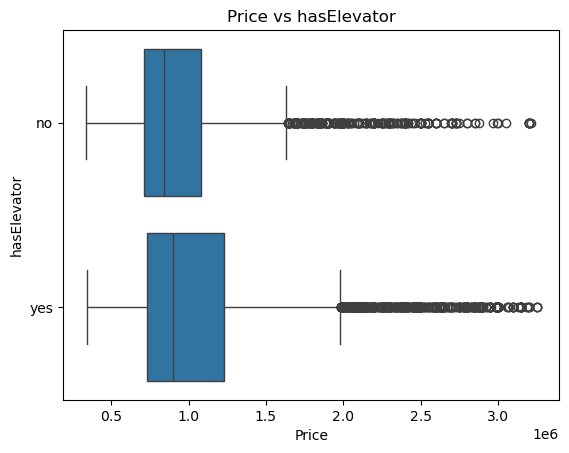

In [28]:
dummy_variables = ['type', 'floorType', 'ownership', 'poiCount', 'hasBalcony', 'hasElevator']


def table(df: pd.DataFrame):
    for dummy in dummy_variables:
        print(f"Price Summary by {dummy.title()}{mappings.get(dummy)}:")
        print(df.groupby(dummy)['price'].describe())
        sns.boxplot(y=dummy, x='price', data=df, orient='h')
        plt.title(f"Price vs {dummy}")
        plt.xlabel("Price")
        plt.ylabel(dummy)
        plt.show()


table(Apartments_extended)

In [29]:
Apartments_extended_numerical = create_dummy_variables(aggregate_data())
datacorr = Apartments_extended_numerical[["price", "squareMeters", "type", "floorType",
                      "centreDistance", "poiCount", "ownership",
                      "hasBalcony", "hasElevator"]]

cor_matrix = datacorr.corr()
print(cor_matrix)

                   price  squareMeters      type  floorType  centreDistance  \
price           1.000000      0.818120  0.137428   0.017092       -0.163187   
squareMeters    0.818120      1.000000  0.128057   0.054239        0.104058   
type            0.137428      0.128057  1.000000  -0.074165        0.253188   
floorType       0.017092      0.054239 -0.074165   1.000000        0.032688   
centreDistance -0.163187      0.104058  0.253188   0.032688        1.000000   
poiCount        0.139885     -0.013294 -0.219304   0.005625       -0.474508   
ownership       0.128397      0.048805  0.096016  -0.005486        0.019186   
hasBalcony      0.030875      0.095134  0.186736  -0.039906        0.186224   
hasElevator     0.083882     -0.008088  0.368712  -0.120841        0.012277   

                poiCount  ownership  hasBalcony  hasElevator  
price           0.139885   0.128397    0.030875     0.083882  
squareMeters   -0.013294   0.048805    0.095134    -0.008088  
type           -0.21

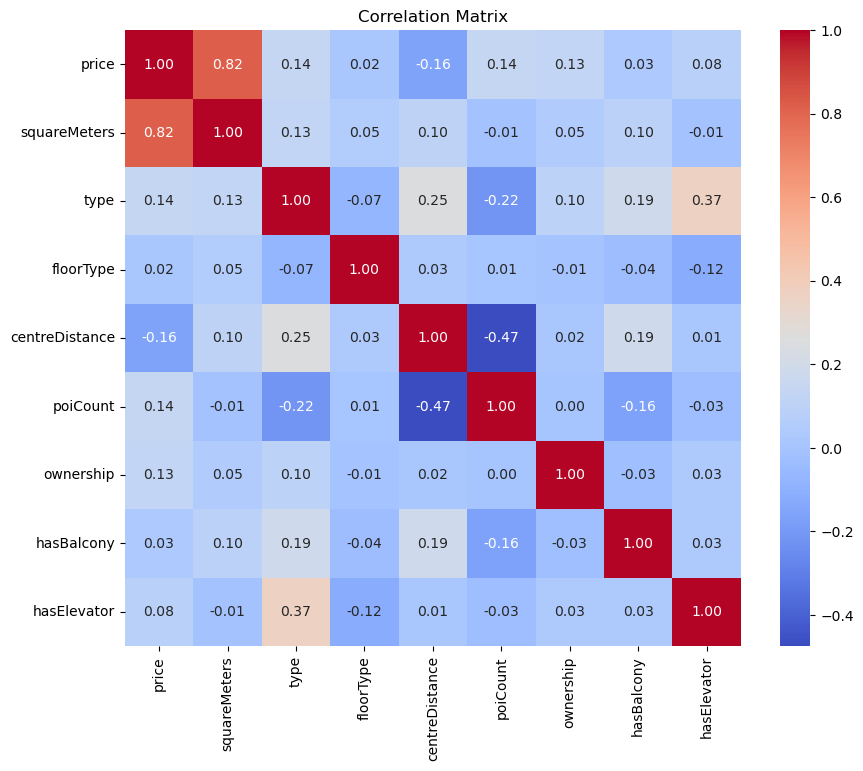

Significant Correlations with 'price' (p < 0.05):
       X               Y         r         p-unc
0  price    squareMeters  0.818120  0.000000e+00
3  price  centreDistance -0.163187  9.277785e-95
4  price        poiCount  0.139885  6.942518e-70
1  price            type  0.137428  1.711492e-67
5  price       ownership  0.128397  4.448512e-59
7  price     hasElevator  0.083882  4.413202e-26
6  price      hasBalcony  0.030875  1.035576e-04
2  price       floorType  0.017092  3.165115e-02


In [30]:
# Correlation matrix with values
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# With significance levels (p-values)
results = pg.pairwise_corr(datacorr, method='pearson')
sig_corrs = results[results['p-unc'] < 0.05]

# Filter to only rows where 'price' is one of the variables
price_corrs = sig_corrs[(sig_corrs['X'] == 'price') | (sig_corrs['Y'] == 'price')]

# Optional: sort by absolute correlation strength
price_corrs = price_corrs.copy()
price_corrs['abs_r'] = price_corrs['r'].abs()
price_corrs = price_corrs.sort_values('abs_r', ascending=False)

# Display cleaned result
print("Significant Correlations with 'price' (p < 0.05):")
print(price_corrs[['X', 'Y', 'r', 'p-unc']])

In [31]:
print(Apartments_extended.isnull().sum())         
print(Apartments_extended.dtypes)                  
print(Apartments_extended.shape)                   
print(Apartments_extended.head())                  


type              0
squareMeters      0
centreDistance    0
poiCount          0
ownership         0
hasBalcony        0
hasElevator       0
price             0
floorType         0
dtype: int64
type              category
squareMeters       float64
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
floorType         category
dtype: object
(15805, 9)
                type  squareMeters  centreDistance poiCount    ownership  \
0       blockOfFlats         77.00           11.43    small  condominium   
1       blockOfFlats         62.20           10.31    small  condominium   
2       blockOfFlats         73.40            5.68   medium  condominium   
3           tenement         50.33            2.41    small  condominium   
4  apartmentBuilding         34.00           10.14    small  condominium   

  hasBalcony hasElevator   price floorType  
0        yes         yes  950000     

In [32]:
# Initial linear regression model (equivalent to regression1)
regression1 = smf.ols('price ~ type + squareMeters + floorType + centreDistance + poiCount + ownership + hasBalcony + hasElevator', data=Apartments_extended).fit()
print(regression1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     5483.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        10:33:26   Log-Likelihood:            -2.1658e+05
No. Observations:               15805   AIC:                         4.332e+05
Df Residuals:                   15794   BIC:                         4.333e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

* Here we get a bit different results. We have higher R-squared and Adj.R-squared value 0.776, in the paper was 0.757,0,756. Larger samples usually capture the characteristics of the aggregate better, thus improving the fit of the model.
*  And all of the coefficents are smaller than the ones in the paper.（More data means that the individual effects of some variables will be “averaged out”, showing a weaker effect on the dependent variable.）
*  Especially for floorType - high, has different direction, here is -8379.9957, before was 989. （This means that the definition or proportion of “high floors” in the sample has changed, or that the apartment corresponding to “high floors” is not more expensive or even cheaper in the new sample (e.g., high floors without an elevator).）
*  And given 1% significance level, the variables before were insignicant, still perform the same, and here we get more insignificant variables - hasBalcony-yes, poiCount-large. （It turns out that the significance is due to small samples with large fluctuations, and that chance differences in small samples create “false significance”.）

In [33]:
# RESET test (fitted)
reset_fitted = linear_reset(regression1, power=2, use_f=True)
print("\nRESET test (fitted):", reset_fitted)

# RESET test (regressor)
reset_regressor = linear_reset(regression1, power=2, use_f=False)
print("\nRESET test (regressor):", reset_regressor)


RESET test (fitted): <F test: F=291.3685487230147, p=9.525476272550607e-65, df_denom=1.58e+04, df_num=1>

RESET test (regressor): <Wald test (chi2): statistic=291.3685487230147, p-value=2.502443699069471e-65, df_denom=1>


Here we get the same results - reject the linearty according to reset test.

In [34]:
# Fitting a nonlinear model regression2
Apartments_extended['log_price'] = np.log(Apartments_extended['price'])
Apartments_extended['squareMeters_2'] = Apartments_extended['squareMeters'] ** 2
Apartments_extended['centreDistance_2'] = Apartments_extended['centreDistance'] ** 2
Apartments_extended['centreDistance_3'] = Apartments_extended['centreDistance'] ** 3

formula2 = 'log_price ~ poly(squareMeters, 2, raw=True) + poly(centreDistance, 3, raw=True) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance'
regression2 = smf.ols('log_price ~ squareMeters + I(squareMeters ** 2) + centreDistance + I(centreDistance ** 2) + I(centreDistance ** 3) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance', data=Apartments_extended).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     4365.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        10:33:27   Log-Likelihood:                 5899.2
No. Observations:               15805   AIC:                        -1.177e+04
Df Residuals:                   15789   BIC:                        -1.164e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

* We have higher R-squared and Adj.R-squared value 0.806, in the paper was 0.796, 0,795.
* And all of the coefficents are smaller than the ones in the paper.
* One variable has different direction - hasElevatoryes:poiCountmedium, here we get -0.0326, in the paper it was 0.003, and before it was insignificant, but here shows significant.（It could be that “medium POI + elevator” occurs more frequently in the new sample, making the model more confident in identifying its marginal impact. And perhaps there is a substitution effect between the positive impact of “elevator” and “POI”: where amenities are sufficient, elevators are not a price determinant.）
* Before there were 3 insignificant variables- type-blockofflats,I(centreDistance ** 3) and poiCountmedium:hasElevatoryes , but here only type-blockofflats is still insignificant. (Larger sample size → smaller standard error → easier to identify the significance of the variable).

In [35]:
# RESET 
print("\nRESET test (fitted):", linear_reset(regression2, power=3, use_f=True))
print("\nRESET test (regressor):", linear_reset(regression2, power=3, use_f=True))


RESET test (fitted): <F test: F=90.53880581456156, p=8.003695594867466e-40, df_denom=1.58e+04, df_num=2>

RESET test (regressor): <F test: F=90.53880581456156, p=8.003695594867466e-40, df_denom=1.58e+04, df_num=2>


* Here we still reject the assumption of linearty, different from the paper.

## DIAGNOSTIC TEST

### Linearity

In [36]:
Apartments_extended['squareMeters2'] = Apartments_extended['squareMeters'] ** 2
Apartments_extended['squareMeters3'] = Apartments_extended['squareMeters'] ** 3
Apartments_extended['centreDistance2'] = Apartments_extended['centreDistance'] ** 2
Apartments_extended['centreDistance3'] = Apartments_extended['centreDistance'] ** 3

reset_model = smf.ols(
    'log_price ~ squareMeters + squareMeters2 + squareMeters3 + '
    'centreDistance + centreDistance2 + centreDistance3 + '
    'type + type:squareMeters + hasBalcony + poiCount + '
    'hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance',
    data=Apartments_extended
).fit()

from statsmodels.stats.anova import anova_lm
anova_result = anova_lm(regression2, reset_model)
print(anova_result)


   df_resid         ssr  df_diff   ss_diff          F        Pr(>F)
0   15789.0  438.650991      0.0       NaN        NaN           NaN
1   15788.0  437.471974      1.0  1.179018  42.549763  7.100157e-11


* The added variable do not significantly increase the explanatory power of the model, so it can be assumed that the model has no serious omitted variable bias (i.e., there are no serious violations of the linearity assumption) - at least from the point of view of the RESET test. (But bigger ss-diff than we get from the original data).

### Normality of residuals

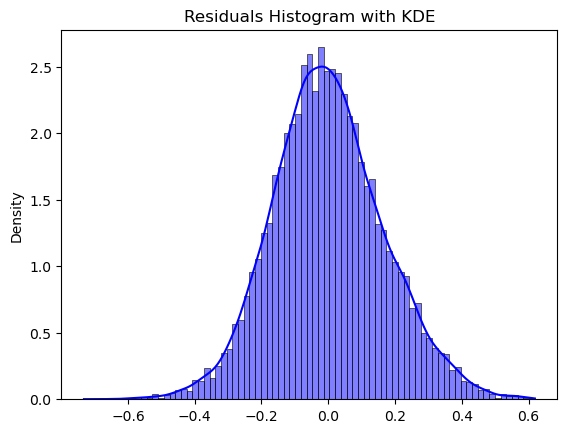

In [37]:
residuals = regression2.resid
sns.histplot(residuals, kde=True, color='blue', stat="density")
plt.title("Residuals Histogram with KDE")
plt.show()

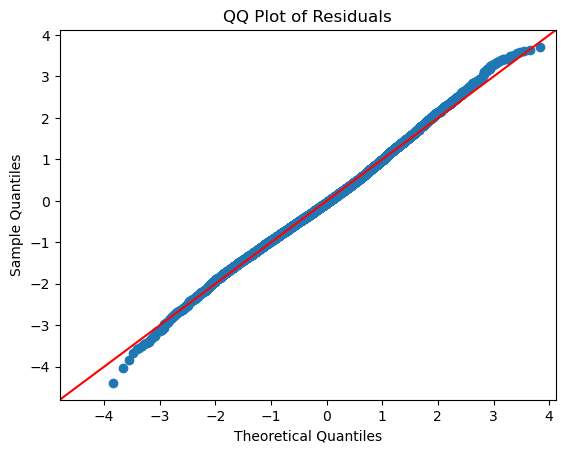

In [38]:
# QQ plot of residuals
sm.qqplot(regression2.resid, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

In [39]:
# Jarque-Bera test
jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print("\nJarque-Bera test: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))



Jarque-Bera test: statistic = 110.5770, p-value = 0.0000


* We got the similar plots and test results as the author did, the assumption of normality is rejected. However, author didn't conduct further modifications for the fact that from the test the distribution of residuals is not normal because of the law of large numbers. 

### Homoscedasticity

In [40]:
# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, regression2.model.exog)
print("\nBreusch-Pagan test:", lzip(['LM stat', 'LM p-value', 'F stat', 'F p-value'], bp_test))


Breusch-Pagan test: [('LM stat', 736.9080865280563), ('LM p-value', 1.2360316907870782e-145), ('F stat', 51.477616166246506), ('F p-value', 5.163580645207081e-151)]


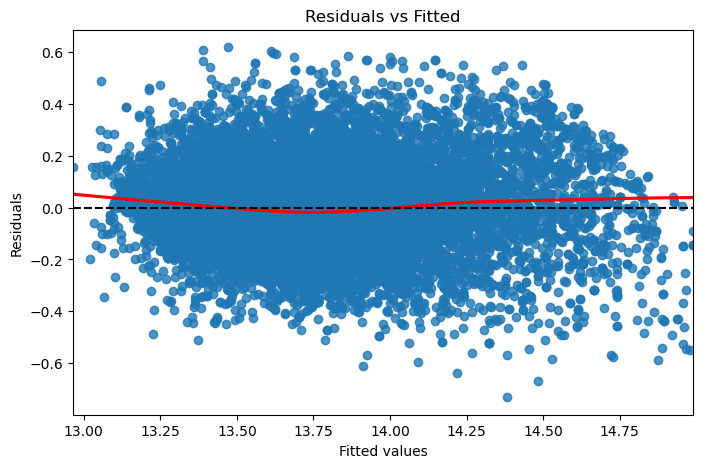

In [41]:
fitted_vals = regression2.fittedvalues
residuals = regression2.resid

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='black', linestyle='--')
plt.show()

* As for homoscedasticity, we got the similar results and plot. This assumption is confirmed by Breusch-Pagan test, in which we reject the H0 
that the regression is homoscedastic.

* To solve this problem we applied a robust variance-covariance matrix to the regression as the author did.

In [42]:
from statsmodels.stats.sandwich_covariance import cov_hc0, cov_hc3
from statsmodels.stats.contrast import ContrastResults
from statsmodels.iolib.summary2 import summary_col
robust_HC0 = regression2.get_robustcov_results(cov_type='HC0')
robust_HC3 = regression2.get_robustcov_results(cov_type='HC3')

print(summary_col([regression2, robust_HC0, robust_HC3], stars=True, model_names=['OLS', 'HC0', 'HC3']))


                                           OLS        HC0        HC3    
------------------------------------------------------------------------
Intercept                               12.7017*** 12.7017*** 12.7017***
                                        (0.0178)   (0.0195)   (0.0196)  
type[T.blockOfFlats]                    -0.0288**  -0.0288**  -0.0288** 
                                        (0.0115)   (0.0123)   (0.0124)  
type[T.apartmentBuilding]               0.0787***  0.0787***  0.0787*** 
                                        (0.0126)   (0.0136)   (0.0137)  
hasBalcony[T.yes]                       0.0160***  0.0160***  0.0160*** 
                                        (0.0030)   (0.0030)   (0.0030)  
poiCount[T.medium]                      0.0502***  0.0502***  0.0502*** 
                                        (0.0064)   (0.0068)   (0.0068)  
poiCount[T.large]                       -0.0000*** -0.0000*** -0.0000***
                                        (0.0000)  

* We can see all of them are significant now. Here the results are very similar to to the ones in the paper, just the coefficients are a bit smaller and more significant. We get a bit higher R-squared and R-squared Adj.
* Only the direction of hasElevator[T.yes]:poiCount[T.medium]  -0.0326 is different than before 0.003, and we get significant 0 for poiCount[T.large] and hasElevator[T.yes]:poiCount[T.large].（These variables may have been less frequent in the original data and the estimates were unstable; In the new data, the combination of “many POIs + elevated buildings” may be increasing (e.g., new development areas in the process of urbanization) and may become a significant influence.）
* So from the larger extended data, we could tell that large Points of interest don't really affect the price of apartment that much.

### Multicollinearity

In [43]:
# VIF test
X = regression2.model.exog
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = regression2.model.exog_names
print("\nVIF Table:\n", vif)


VIF Table:
     VIF Factor                                 features
0   180.559292                                Intercept
1    17.968973                     type[T.blockOfFlats]
2    17.894664                type[T.apartmentBuilding]
3     1.097329                        hasBalcony[T.yes]
4     3.954465                       poiCount[T.medium]
5          NaN                        poiCount[T.large]
6     1.458436                       hasElevator[T.yes]
7     5.563798                 ownership[T.condominium]
8     3.759040    hasElevator[T.yes]:poiCount[T.medium]
9          NaN     hasElevator[T.yes]:poiCount[T.large]
10   28.077122                             squareMeters
11   17.310088        type[T.blockOfFlats]:squareMeters
12   19.457020   type[T.apartmentBuilding]:squareMeters
13   21.294662                     I(squareMeters ** 2)
14   97.774293                           centreDistance
15   14.965599  ownership[T.condominium]:centreDistance
16  365.774829                   I(

 * The variables poiCount[T.large] and hasElevator[T.yes]:poiCount[T.large] are not included in the VIF table likely because they have been dropped due to perfect multicollinearity. While most VIF values are slightly lower than those in the paper—possibly due to a larger, more stable dataset—several are still above the threshold of 10. This is expected given the inclusion of polynomial and interaction terms, which naturally introduce multicollinearity.

# PROBLEMS WITH DATA

In [44]:
influence = OLSInfluence(regression1)
lev = influence.hat_matrix_diag                     
rstd = influence.resid_studentized_internal 
cookd = influence.cooks_distance[0] 

lev_threshold = 2 * len(regression1.params) / len(Apartments_extended)
cook_threshold = 4 / len(Apartments_extended)

num_high_leverage = np.sum(lev > lev_threshold)
num_outliers = np.sum(np.abs(rstd) > 2)
num_high_cookd = np.sum(cookd > cook_threshold)

print("Leverage threshold:", lev_threshold)
print("Cook's distance threshold:", cook_threshold)
print("Number of high leverage points:", num_high_leverage)
print("Number of standardized residual outliers:", num_outliers)
print("Number of high Cook's distance points:", num_high_cookd)

Leverage threshold: 0.001518506801645049
Cook's distance threshold: 0.0002530844669408415
Number of high leverage points: 251
Number of standardized residual outliers: 823
Number of high Cook's distance points: 905


In [45]:
lev = pd.Series(influence.hat_matrix_diag, index=Apartments_extended.index)
print(type(lev))

<class 'pandas.core.series.Series'>


In [46]:
diagnostics = pd.DataFrame({
    'lev': lev,
    'rstd': rstd,
    'cookd': cookd
})
nontypical = diagnostics[
    (diagnostics['lev'] > lev_threshold) &
    (np.abs(diagnostics['rstd']) > 2) &
    (diagnostics['cookd'] > cook_threshold)
].index
print("Number of nontypical observations:", len(nontypical))
print("Nontypical index values (meeting all 3 conditions):")
print(nontypical.tolist())

Number of nontypical observations: 78
Nontypical index values (meeting all 3 conditions):
[28, 134, 185, 292, 357, 372, 483, 907, 1497, 2051, 2306, 2461, 2555, 2570, 2603, 2669, 2794, 2800, 2876, 2877, 2884, 2889, 3080, 3225, 3604, 3615, 3793, 3960, 4088, 4235, 4379, 4385, 4537, 5070, 5447, 5530, 5567, 5829, 5906, 6178, 6340, 6653, 6660, 6722, 6791, 7029, 7156, 7240, 9194, 9343, 9361, 9621, 9796, 10395, 10762, 10961, 11432, 11695, 12677, 12959, 13276, 13328, 14291, 14953, 15584, 16370, 18850, 20548, 20684, 21267, 23531, 23896, 24429, 24548, 24635, 24716, 24976, 25310]


For the extended dataset, 251 observations with high leverage, 823 standardized residual outliers, and 905 observations with high Cook's distance. There are 78 observations that meet the high leverage, high standard residual, and high Cook distance at the same time.

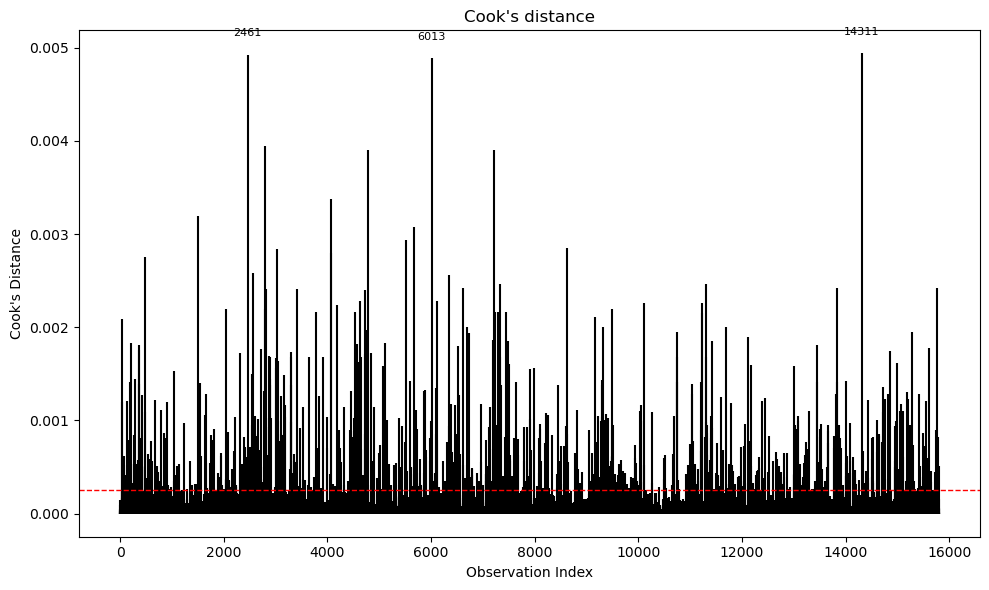

In [47]:
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cookd)), cookd, linefmt='k-', markerfmt=' ', basefmt=" ")

plt.axhline(y=cook_threshold, color='red', linestyle='--', linewidth=1)

top_n = 3
top_indices = np.argsort(cookd)[-top_n:]
for i in top_indices:
    plt.text(i, cookd.iloc[i] + 0.0002, str(i), fontsize=8, color='black', ha='center')
    
plt.title("Cook's distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.tight_layout()
plt.show()

The three observations with the highest Cook distance are the 2462nd, 6014th, and 14312nd observations, because Python index starts from 0.

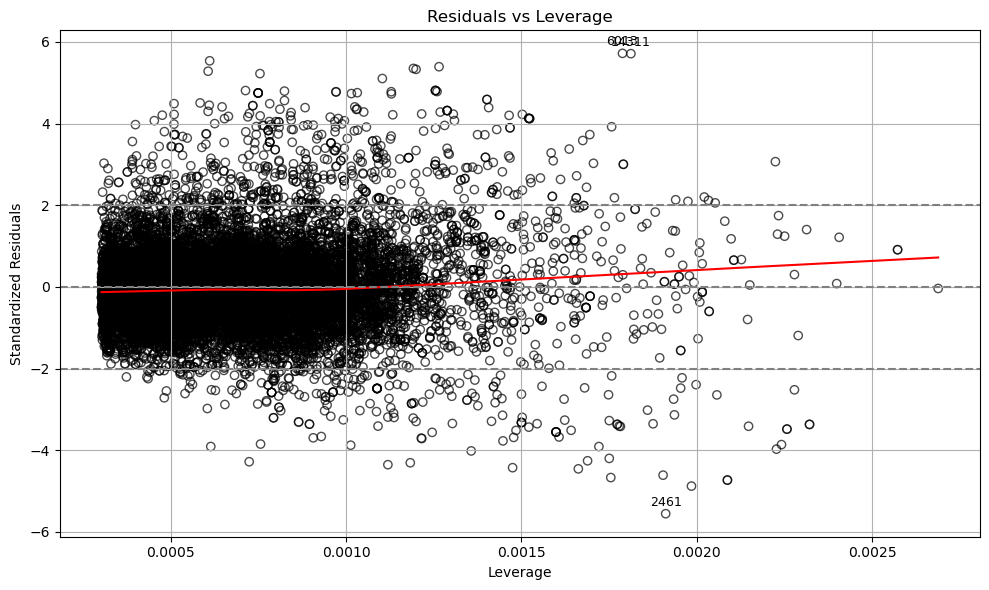

In [48]:
lev = pd.Series(influence.hat_matrix_diag, index=Apartments_extended.index)

lowess = sm.nonparametric.lowess
trend = lowess(rstd, lev)

plt.figure(figsize=(10, 6))
plt.scatter(lev, rstd, facecolors='none', edgecolors='black', alpha=0.7)
plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='-', label='Trend')

for i in top_indices:
    plt.text(lev.iloc[i], rstd.iloc[i] + 0.2, str(i), fontsize=9, ha='center')

plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=2, color='gray', linestyle='--')
plt.axhline(y=-2, color='gray', linestyle='--')
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage")
plt.grid(True)
plt.tight_layout()
plt.show()

The red trend line shows a slightly upward slope compared to the original data, indicating that standardized residuals also tend to increase as leverage increases. This suggests that the model may not be fitting well for high-leverage observations.

NameError: name 'top10_idx' is not defined

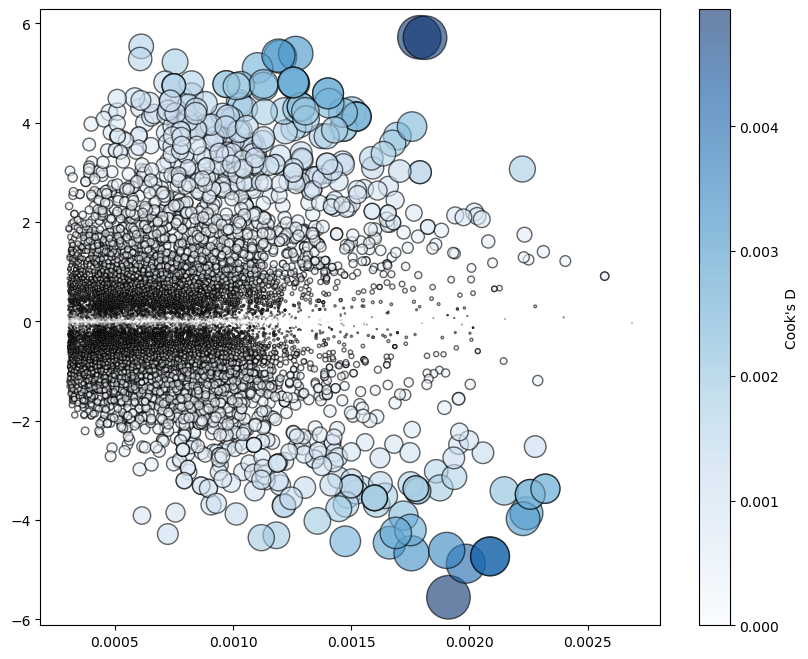

In [49]:
sizes = 200000 * diagnostics['cookd']  
colors = diagnostics['cookd']

plt.figure(figsize=(10, 8))
sc = plt.scatter(diagnostics['lev'], diagnostics['rstd'],
                 s=sizes, c=colors, cmap='Blues', alpha=0.6, edgecolors='black')

cbar = plt.colorbar(sc)
cbar.set_label("Cook's D")

lev_rank = diagnostics['lev'].rank(ascending=False)
rstd_rank = np.abs(diagnostics['rstd']).rank(ascending=False)
cookd_rank = diagnostics['cookd'].rank(ascending=False)
diagnostics['total_abnormal_rank'] = lev_rank + rstd_rank + cookd_rank

top10_indices = diagnostics.sort_values('total_abnormal_rank').head(10).index
for i in top10_idx:
    plt.text(diagnostics['lev'][i], diagnostics['rstd'][i] + 0.2,
             str(i), fontsize=8, color='black', ha='center')
    
plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
plt.axvline(x=lev_threshold, color='blue', linestyle='--', linewidth=1)

plt.title("Leverage and residuals", fontsize=14, weight='bold')
plt.xlabel("Hat-Values")
plt.ylabel("Standardized Residuals")
plt.suptitle("Circle size is proportional to Cook's distance", fontsize=10, y=0.91, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(diagnostics.loc[top10_indices][['lev', 'rstd', 'cookd', 'total_abnormal_rank']])

In [ ]:
row_ranks = [diagnostics.index.get_loc(i) for i in top10_indices]
print(row_ranks)

We decided to remove the top 10 most influential outliers from the dataset. These include the three observations with the largest Cook distances, which are the 2642nd, 6014th, and 14312nd observations.

# Reregression based on dataset that outliers was removed
## Reregression on the most original model

In [ ]:
Apartment_new = Apartments_extended.drop(top10_indices)
regression1_new = smf.ols('price ~ type + squareMeters + floorType + centreDistance + poiCount + ownership + hasBalcony + hasElevator', data=Apartment_new).fit()
print(regression1_new.summary())

In [ ]:
# RESET test (fitted)
reset_fitted_regression1_new = linear_reset(regression1_new, power=3, use_f=True)
print("\nRESET test for regession1_new (fitted):", reset_fitted_regression1_new)

# RESET test (regressor)
reset_regressor_regression1_new = linear_reset(regression1_new, power=3, use_f=True)
print("\nRESET test for regression1_new (regressor):", reset_regressor_regression1_new)

regression1_new_residuals = regression1_new.resid
jb_stat, jb_pvalue, _, _ = jarque_bera(regression1_new_residuals)
print("\nJarque-Bera test for regression1_new: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))

bp_test_regression1_new = het_breuschpagan(regression1_new_residuals, regression1_new.model.exog)
print("\nBreusch-Pagan test for regression1_new")
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test_regression1_new):
    print(f"{name}: {value:.4f}")

The tests for linearity, normality, and homoskedasticity still fail. 

## Reregression on improved model

In [ ]:
regression2_new = smf.ols(
                          
    '''log_price ~ squareMeters + I(squareMeters ** 2) 
       + centreDistance + I(centreDistance ** 2) 
       + I(centreDistance ** 3) + type 
       + type:squareMeters + hasBalcony 
       + poiCount + hasElevator + ownership 
       + hasElevator:poiCount + ownership:centreDistance''', 
       data=Apartment_new
).fit()

print(regression2_new.summary())

In [ ]:
# RESET test (fitted)
reset_fitted_regression2_new = linear_reset(regression2_new, power=3, use_f=True)
print("\nRESET test for regession2_new (fitted):", reset_fitted_regression2_new)

# RESET test (regressor)
reset_regressor_regression2_new = linear_reset(regression2_new, power=3, use_f=True)
print("\nRESET test for regression2_new (regressor):", reset_regressor_regression2_new)

regression2_new_residuals = regression2_new.resid
jb_stat, jb_pvalue, _, _ = jarque_bera(regression2_new_residuals)
print("\nJarque-Bera test for regression2_new: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))

bp_test_regression2_new = het_breuschpagan(regression2_new_residuals, regression2_new.model.exog)
print("\nBreusch-Pagan test for regression2_new")
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test_regression2_new):
    print(f"{name}: {value:.4f}")

After removing outliers, the P-value of the Jarque-Bera test does not change, P-values of the rest test and the Breusch-Pagan test are higher, but they still reject the null hypothesis of linearity, normality, and homoskedasticity.

In [ ]:
reset_model_new = smf.ols(
    'log_price ~ squareMeters + squareMeters2 + squareMeters3 + '
    'centreDistance + centreDistance2 + centreDistance3 + '
    'type + type:squareMeters + hasBalcony + poiCount + '
    'hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance',
    data=Apartment_new
).fit()

from statsmodels.stats.anova import anova_lm
anova_result_new = anova_lm(regression2_new, reset_model_new)
print(anova_result_new)

Manually checking by adding a non-linear variable squareMeters3. P-vale < 0.05, indicating that the added variables do not significantly increase the explanatory power of the model, so it can be assumed that the model has no serious omitted variable bias. This model we got quit high R-squard, which is 0.806. Based on the above analysis, we decided this is our final model.

In [ ]:
fitted_vals_regression2_new = regression2_new.fittedvalues
residuals_regression2_new = regression2_new.resid

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='black', linestyle='--')
plt.show()

This residual plot appears to perform well overall, with no significant issues in model fitting, indicating that the linear regression model is appropriate. However, the model may exhibit slight bias at the boundaries of the fitted values.

# INTERPRETATION OF FINAL RESULTS

To sum up, the final regression is the following form:

\
\begin{aligned}
\log(\text{price}) &= 12.7141 + 0.0255 \cdot \text{squareMeters} - 0.00007 \cdot \text{squareMeters}^2 \\
&\quad - 0.0582 \cdot \text{centreDistance} + 0.0041 \cdot \text{centreDistance}^2 - 0.0001 \cdot \text{centreDistance}^3 \\
&\quad - 0.0344 \cdot \text{type}_{\text{blockOfFlats}} + 0.0754 \cdot \text{type}_{\text{apartmentBuilding}} \\
&\quad + 0.0161 \cdot \text{hasBalcony} + 0.0510 \cdot \text{poiCount}_{\text{medium}} + 0.0000 \cdot \text{poiCount}_{\text{large}} \\
&\quad + 0.0677 \cdot \text{hasElevator} + 0.1020 \cdot \text{ownership}_{\text{condominium}} \\
&\quad - 0.0013 \cdot (\text{type}_{\text{blockOfFlats}} \times \text{squareMeters}) \\
&\quad - 0.0011 \cdot (\text{type}_{\text{apartmentBuilding}} \times \text{squareMeters}) \\
&\quad - 0.0034 \cdot (\text{poiCount}_{\text{medium}} \times \text{hasElevator}) \\
&\quad + 0.0000 \cdot (\text{poiCount}_{\text{large}} \times \text{hasElevator}) \\
&\quad - 0.0062 \cdot (\text{ownership}_{\text{condominium}} \times \text{centreDistance})
\end{aligned}


- **Size**：The coefficient on size is 0.0255 and on size squared is –0.00007, implying a concave (inverse U-shaped) relationship between size and price. Taking the derivative of log(price) with respect to size and setting it to zero gives the turning point at: $Size = \frac{0.0255}{2 \times 0.00007} = 182.14$. This means price increases with size up to 182.14 square meters—at a rate of 2.55% per additional square meter—and decreases beyond that point at a rate of 0.007% per square meter.
- **Center Distance**: The coefficients on center distance are: linear term = –0.0582, squared term = 0.0041, and cubic term = –0.0001, indicating a non-linear relationship between house pricing and center distance. As the distance from the city center increases, the housing price initially decreases (because the linear term is negative), but the rate of decrease slows down as the distance increases or even rises briefly (because the quadratic term is positive), and finally may accelerate again at long distances (the cubic term is negative).
- **Apartment type**: The coefficient for blocks of flats is -0.0344, meaning these apartments are priced 3.44% lower than tenements. For apartment buildings, the coefficient is 0.0754, indicating they are priced 7.54% higher than tenements.
- **Has balcony** : Semi-elasticity: coefficient 0.0161 means that apartments with a balcony have generally  1.61 higher prices than those without one.
- **Has elevator** : Semi-elasticity: coefficient 0.0677 means that apartments with an elevator have generally  6.77% higher prices than those without one.
- **Type of points of interest**: A coefficient of 0.0510 means apartments with a medium number of nearby interest points are 5.1% more expensive than those with few. A coefficient of 0.0000 means apartments with many nearby interest points have the same price as those with few(no differnce). This result is not realistic.
- **Ownership**: A coefficient 0.1020 means that apartments of condominium type ownership have generally 10.2 % higher prices than those with cooperative type.
- **Interaction between apartment type and size**: The value of apartment type changes with size. For the same size, block of flats are priced 0.13% lower than tenements, and apartment buildings are 0.11% lower. This is the opposite of the earlier assumption.
- **Interaction between points type of interest and has elevator**: For apartments with an elevator, those near a medium number of interest points are 0.34% cheaper than those near a small number. However, those near a large number of interest points have the same price with those near a small number. This result is not realistic.
- **Interaction between ownership and center distance**: With the same distance to city center, condominium type ownership have generally  0.62% lower prices than those with cooperative type.

# HYPOTHESIS VERIFICATION

After running regression based on extended data, let's vertify our orignial assumption using the regrssion result:
- The first hypothesis is rejected: tenements are not the cheapest — flats are the cheapest, and apartment buildings are the most expensive.

- The second hypothesis is also rejected: there is a non-linear link between size and price, but prices don’t just keep rising. They go up and then fall.

- The third hypothesis can't be rejected or confirmed because the floor type variable wasn’t significant, so I removed it from the model.

- The fourth hypothesis is rejected too: price doesn’t just drop as distance to the city center increases. As distance from the city center increases, housing prices first go down, then slow their drop or even rise a bit, and finally may drop again more quickly when far from the center.

- The fifth hypothesis is reject: Apartments with a medium number of nearby interest points tend to be more expensive than those with few, while apartments with many interest points show no price difference. This result seems unrealistic. This is different with paper.

- The sixth, seventh, and eighth hypotheses are also accepted: apartments in condominiums are more expensive than in co-ops, those with elevators cost more than those without, and balconies add value.

# CONCLUSIONS AND SUMMARY

The results that are different from the original data regression are as follows： 
- The adjusted R-squared of our regression results is 0.806, higher than the previous 0.795. This means that our variables explain 80.6.5% of the model, better than the previous model.
- The coefficients of almost all independent variables are smaller than the original ones, maybe because with more data, the impact of some variables may become less noticeable, as their individual effects get averaged out.
- Apartments near more points of interest are the same price as apartments near fewer points of interest for the extended dataset, rather than being more expensive.
- Whether the apartment has an elevator only affects the relationship between the nearby medium-interest points and the price, while whether the apartment has an elevator does not affect the relationship between a large number of nearby data points and the price.